In [ ]:
!pip install geopandas shapely pyproj folium contextily

In [ ]:
!pip install pytrends statsmodels scipy

In [ ]:
# Imports
# Geometry
from shapely.geometry import Point
from shapely.geometry import Polygon

# Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import folium
from IPython.display import display
import contextily as ctx

# Projections
import pyproj
from pyproj import CRS, Transformer

# Data handling
import geopandas as gpd
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
from google.colab import drive
from pytrends.request import TrendReq

# Models
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.tsa.stattools as smt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read Data
archivo_xlsx = '/content/drive/MyDrive/Diversa/PUCE/base suicidios.xlsx'
df1 = pd.read_excel(archivo_xlsx)

# Shape file
ecu_shp = gpd.read_file("/content/drive/MyDrive/Diversa/PUCE/shp_Ecuador/nxprovincias.shp")
if ecu_shp.crs is None:
    ecu_shp.crs = 'epsg:32717'
ecu_shp = ecu_shp.to_crs('epsg:4326')
ecu_shp = ecu_shp[['DPA_PROVIN', 'geometry']]

In [ ]:
df1.head()

,provincia,fuente1,sexo,año_f,mes_fall,mes_fall1,edad,cod_eda,cau,cau1d,cau2d,cau3d,año,edad2,n,cie10_des,GBD,FECHA
0,02 Bolívar,EDG_2011,Mujer,2011,7,7,26,4 Años (1 a 115 años de edad),X609,X,X6,X60,2011,26,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2011-07-28
1,02 Bolívar,EDG_2011,Hombre,2011,8,8,23,4 Años (1 a 115 años de edad),X609,X,X6,X60,2011,23,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2011-08-28
2,18 Tungurahua,EDG_2012,Mujer,2012,6,6,14,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,14,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-06-28
3,16 Pastaza,EDG_2012,Hombre,2012,2,2,21,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,21,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-02-28
4,16 Pastaza,EDG_2012,Hombre,2012,2,2,34,4 Años (1 a 115 años de edad),X609,X,X6,X60,2012,34,1,X609 Envenenamiento autoinfligido intencionalm...,Causas externas de mortalidad y morbilidad,2012-02-28


In [ ]:
df_pares = df1[['cau3d', 'cie10_des']].drop_duplicates().reset_index(drop=True)
# Renombrar las columnas para 'Codigo' y 'Nombre'
df_pares.columns = ['Codigo', 'Nombre']
# Exportar el DataFrame
df_pares.to_csv("/content/drive/MyDrive/Diversa/PUCE/codigos.csv", index=False)

In [ ]:
## Subset, clean and rename df

# Rename
column_names_in_english = {
    'provincia': 'province',
    'sexo': 'gender',
    'edad': 'age',
    'cie10_des': 'description',
    'FECHA': 'date'
}
df1.rename(columns=column_names_in_english, inplace=True)

# Clean Description
df1['description'] = df1['description'].str.extract(' (.*)')
description_translation = {
    'Envenenamiento autoinfligido intencionalmente por': 'Self-poisoning',
    'Lesión autoinfligida intencionalmente por ahorcamiento': 'Self-hanging',
    'Lesión autoinfligida intencionalmente por objeto cortante': 'Self-harm with sharp object',
    'Lesión autoinfligida intencionalmente al saltar desde un lugar elevado': 'Self-harm by jumping from high place'
}
df1['description'] = df1['description'].replace(description_translation)

# Make age range
df1['age'] = df1['age'].replace(999, 99)
age_bins = [0, 4, 9, 14, 19, 24, 34, 44, 54, 64, 74, 84, 100]
age_labels = [
    "Infants and toddlers (0-4)",
    "Children (5-9)",
    "Pre-teens (10-14)",
    "Teens (15-19)",
    "Young adults (20-24)",
    "Adults (25-34)",
    "Middle-aged adults (35-44)",
    "Older adults (45-54)",
    "Seniors (55-64)",
    "Retirement age (65-74)",
    "Elderly (75-84)",
    "Very elderly (+85)"
]
df1['age_range'] = pd.cut(df1['age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

# Clean gender
gender_translation = {
    'Hombre': 'M',
    'Mujer': 'F'
}
df1['gender'] = df1['gender'].replace(gender_translation)

# Clean province and get the geometry
df1['province_code'] = df1['province'].str.extract('(\d+)')
df1['province'] = df1['province'].str.extract('([^\d]+)')
df1 = df1.merge(ecu_shp, left_on='province_code', right_on='DPA_PROVIN', how='left')
columns_to_keep = ['date','province', 'province_code', 'geometry','gender','age','age_range','description']

df1 = df1[columns_to_keep]

In [ ]:
df1.dtypes

date             datetime64[ns]
province                 object
province_code            object
geometry               geometry
gender                   object
age                       int64
age_range              category
description              object
dtype: object

In [ ]:
df1.head()

,date,province,province_code,geometry,gender,age,age_range,description
0,2011-07-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",F,26,Adults (25-34),Self-poisoning
1,2011-08-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",M,23,Young adults (20-24),Self-poisoning
2,2012-06-28,Tungurahua,18,"POLYGON ((-78.40470 -0.98958, -78.40439 -0.991...",F,14,Pre-teens (10-14),Self-poisoning
3,2012-02-28,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,21,Young adults (20-24),Self-poisoning
4,2012-02-28,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,34,Adults (25-34),Self-poisoning


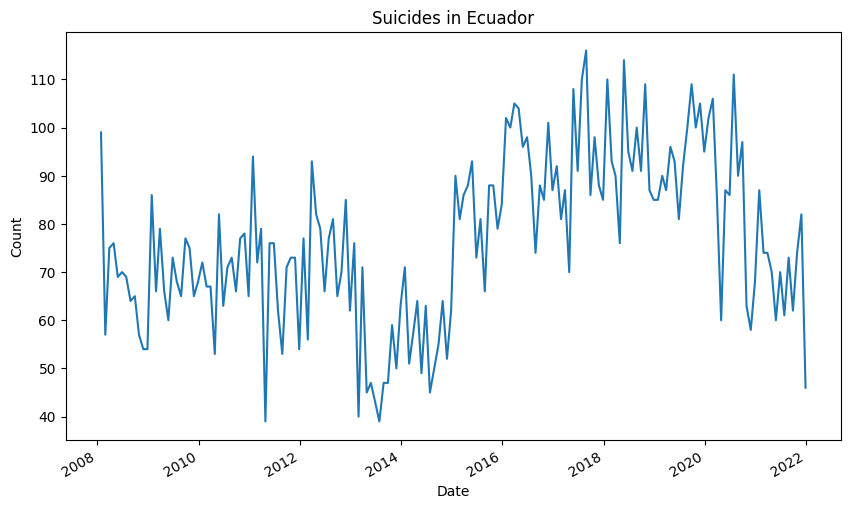

In [ ]:
df1 = df1.copy()
df1['date'] = pd.to_datetime(df1['date'])
df_grouped = df1[df1['date'].dt.year >= 2008].groupby('date').size()
df_grouped.plot(kind='line', figsize=(10, 6))
plt.title('Suicides in Ecuador')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

In [ ]:
df_grouped.sum() + 1170

14046

In [ ]:
df1.groupby('age_range').size().sort_values(ascending=False)


age_range
Adults (25-34)                2859
Teens (15-19)                 2116
Young adults (20-24)          2093
Middle-aged adults (35-44)    1687
Older adults (45-54)          1246
Seniors (55-64)                990
Pre-teens (10-14)              835
Retirement age (65-74)         605
Elderly (75-84)                325
Very elderly (+85)             106
Children (5-9)                  19
Infants and toddlers (0-4)       0
dtype: int64

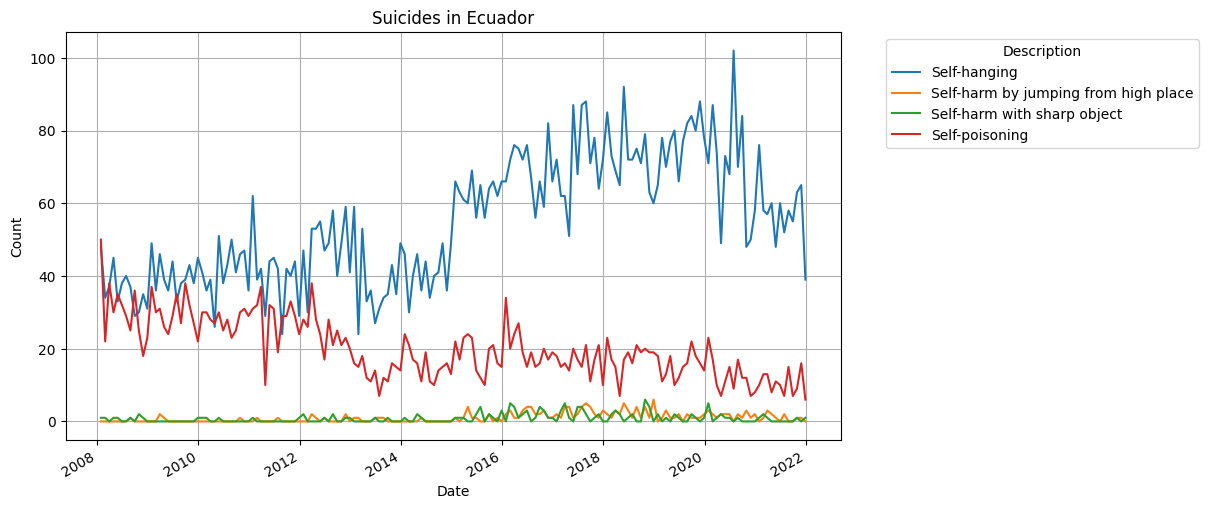

In [ ]:
# Group the data by date and description
df_grouped = df1[df1['date'].dt.year >= 2008].groupby(['date', 'description']).size().unstack(fill_value=0)

# Plot a line for each description
df_grouped.plot(kind='line', figsize=(10, 6))

plt.title('Suicides in Ecuador')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Description', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

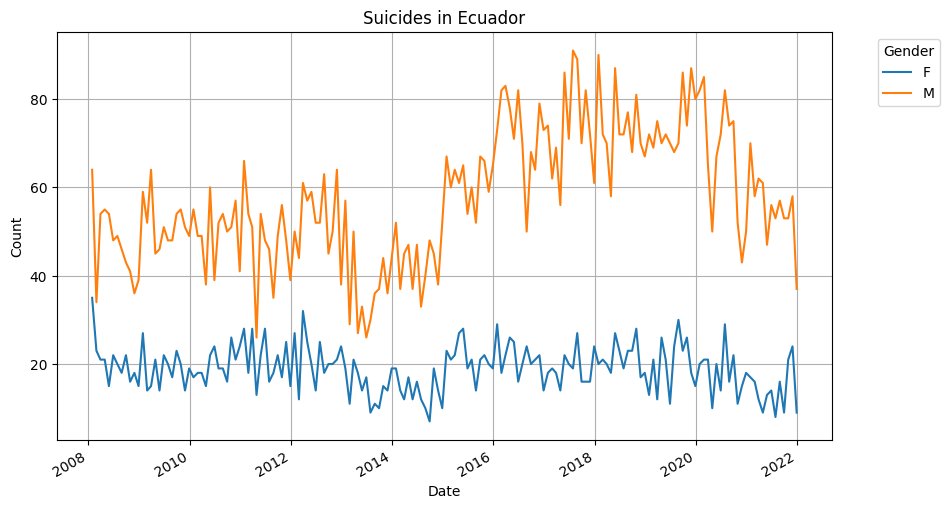

In [ ]:
# Group the data by date and description
df_grouped = df1[df1['date'].dt.year >= 2008].groupby(['date', 'gender']).size().unstack(fill_value=0)

# Plot a line for each description
df_grouped.plot(kind='line', figsize=(10, 6))

plt.title('Suicides in Ecuador')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

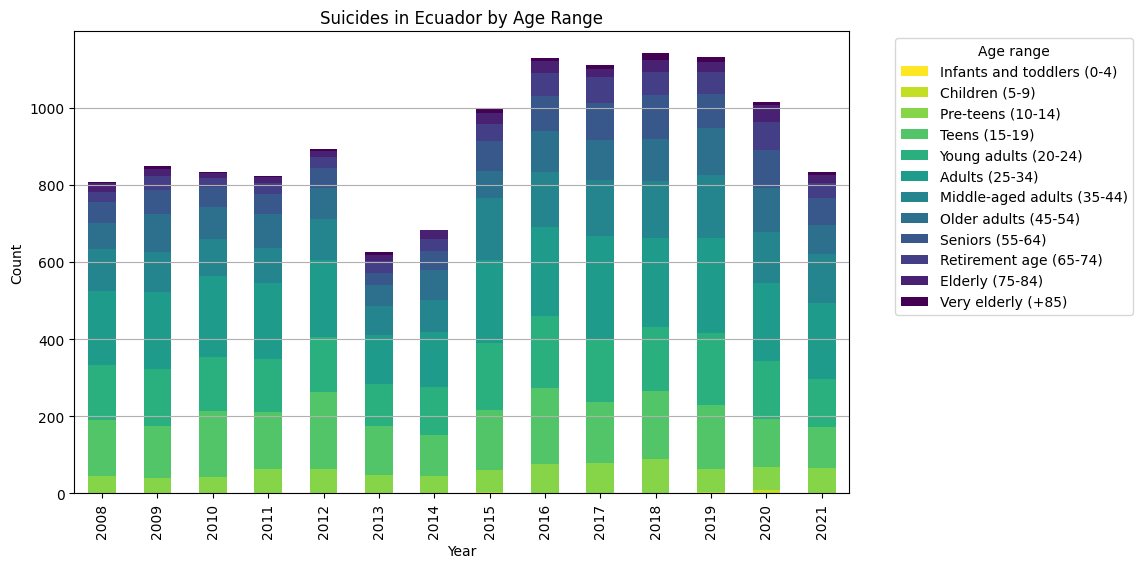

In [ ]:
# Group the data by year and age_range to get the count for each combination
df_grouped = df1[df1['date'].dt.year >= 2008].groupby([df1['date'].dt.year, 'age_range']).size().unstack(fill_value=0)

# Plot a stacked bar plot with years on the X-axis and counts on the Y-axis
df_grouped.plot(kind='bar', stacked=True, figsize=(10,6), cmap='viridis_r')

plt.title('Suicides in Ecuador by Age Range')
plt.xlabel('Year')
plt.ylabel('Count')  # Cambia el título del eje Y a "Count"
plt.legend(title='Age range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()


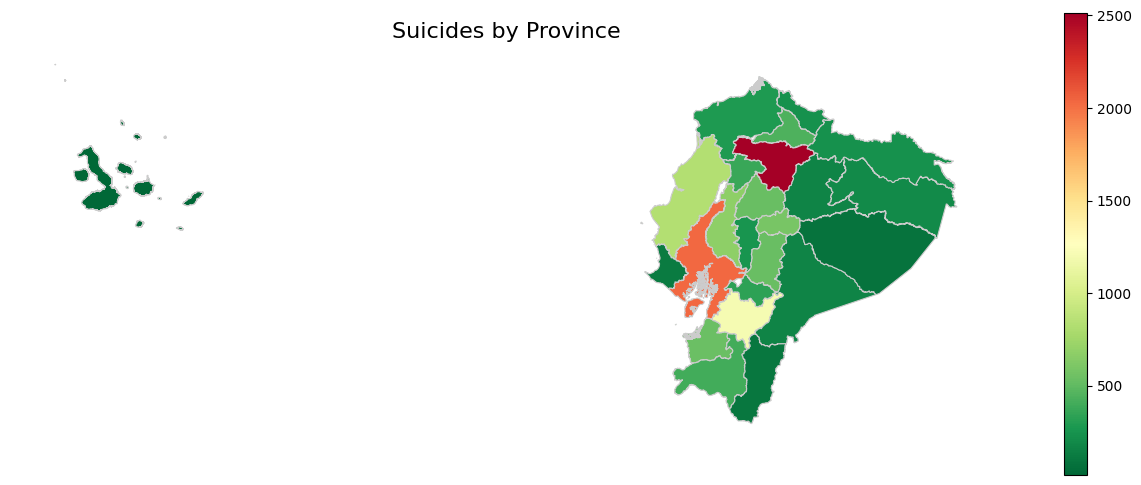

In [ ]:
# Group by province and calculate the total number of cases
province_counts = df1.groupby(['province', 'geometry']).size().reset_index(name='count')

# Create a GeoDataFrame with the province geometries and case counts
province_count = gpd.GeoDataFrame(province_counts, geometry='geometry')

# Create a larger figure
fig, ax = plt.subplots(1, 1, figsize=(16, 10))  # Adjust the figure size as needed

# Plot the map with a smaller color legend
province_count.plot(
    column='count',
    cmap='RdYlGn_r',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'shrink': 0.6}  # Adjust the 'shrink' parameter to control legend size
)

# Set plot title and axis labels
ax.set_title('Suicides by Province', fontsize=16)
ax.set_axis_off()
plt.show()



In [ ]:
province_count

,province,geometry,count
0,Azuay,"POLYGON ((-78.56954 -2.55865, -78.56920 -2.558...",1202
1,Bolívar,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",256
2,Carchi,"POLYGON ((-78.49647 1.19776, -78.49573 1.19763...",237
3,Cañar,"POLYGON ((-78.56954 -2.55865, -78.57007 -2.559...",336
4,Chimborazo,"POLYGON ((-78.35800 -1.52162, -78.35800 -1.521...",534
5,Cotopaxi,"POLYGON ((-78.42185 -0.71691, -78.42185 -0.716...",534
6,El Oro,"MULTIPOLYGON (((-80.20645 -3.43884, -80.20748 ...",540
7,Esmeraldas,"MULTIPOLYGON (((-79.90438 0.27876, -79.90431 0...",285
8,Galápagos,"MULTIPOLYGON (((-89.66637 -1.34547, -89.66625 ...",19
9,Guayas,"MULTIPOLYGON (((-80.16401 -3.01416, -80.16472 ...",2026


# Literature Review

| Author(s)      | Paper Title                                                                                                      | Correlation Method | Key Words (Spanish)                                                                                      |
|----------------|------------------------------------------------------------------------------------------------------------------|--------------------|----------------------------------------------------------------------------------------------------------|
| Borge et al    | [How Search Engines Handle Suicide Queries](https://tsjournal.org/index.php/jots/article/view/16)                 | Lag effect         | que tan doloroso es cortarse las venas, <br> mejores pastillas para una sobredosis, <br> me quedé sin esperanzas, <br> matarse, <br> suicidio, <br> es doloroso ahorcarse, <br> donde está el mejor lugar para dispararse en la cabeza, <br> la manera más facil de asfixiarse, <br> sala de chat de suicidio, <br> cual es el modo más facil de envenenarme |
| Lopez-Agudo    | [The association between internet searches and suicide in Spain](https://www.sciencedirect.com/science/article/abs/pii/S0165178120301001?via%3Dihub) | Pearson Pairwise   | suicidarse, <br> como suicidarse, <br> suicidarse sin dolor, <br> formas de suicidarse, <br> como morir, <br> como suicidarse con pastillas, <br> suicidarse con pastillas, <br> quiero suicidarme, <br> quiero suicidarme sin dolor, <br> telefono de esperanza, <br> telefono suicidio, <br> como suicidarse sin sufir |
| Lee et al    | [Search trends preceding increases in suicide: <br> A cross-correlation study of monthly Google search volume and suicide rate using transfer function models](https://www.sciencedirect.com/science/article/pii/S0165032719323572#:~:text=Cross,%E2%80%A2) | Pearson Pairwise   | Trastorno del estado de ánimo, <br> Desesperación, <br> Depresión, <br> Trastorno depresivo mayor, <br> Nostalgia, <br> Ansiedad, <br> Trastorno de ansiedad generalizada, <br> Trastorno de ansiedad, <br> Ataque de pánico, <br> Trastorno de pánico, <br> Fobia, <br> Agitación, <br> Trastorno del sueño, <br> Problema del sueño, <br> Problema para dormir, <br> No puedo dormir, <br> No puedo conciliar el sueño, <br> Insomnio, <br> Estrés, <br> Agotamiento, <br> Fatiga, <br> Distrés, <br> Divorcio, <br> Separación, <br> Ruptura, <br> Aislamiento social, <br> Apoyo social, <br> Soledad, <br> Problema de relación, <br> Problema interpersonal, <br> Trauma, <br> Trastorno de estrés postraumático, <br> Abuso, <br> Abuso sexual, <br> Abuso verbal, <br> Abuso físico, <br> Abuso mental, <br> Desempleo, <br> Despedido, <br> Perder el trabajo |


In [ ]:
# Define your keywords and other parameters
keyword_lists = {
    'keywords_neutral' : ['suicidio adolescente', 'suicidio adulto', 'suicidio'],
    'keywords_search' : ['cómo suicidarse + como suicidarse', 'metodos de suicidio + método de suicidio', 'Venenos para suicidio + suicidio por envenenamiento', 'nota de suicidio'],
    'keywords_prevention' : ['psiquiatra + psiquiatra telefono', 'ayuda psicologica + psicologo + psicologo telefono', 'psicoterapia + terapia psicologica + necesito terapia'],
    'keywords_mood' : ['trastorno bipolar + soy bipolar + bipolaridad', 'ansiedad + tengo ansiedad + que es la ansiedad', 'panico + ataques de panico + tengo panico', 'fobia + tengo miedo'],
    'keywords_stress' : ['cansancio + estoy agotado + burout', 'ruptura + divorcio + infidelidad', 'me siento solo + no tengo amigos + necesito apoyo', 'no puedo dormir + trastorno del sueño + no tengo sueño + insomnio'],
    'keywords_traumas' : ['fui abusada + abuso sexual + fui abusada sexualmente', 'abuso psicologico + abuso verbal + abuso laboral', 'bullying + me molestan mis amigos + me molestan mis compañeros + se burlan de mi'],
    'keywords_lgbti' : ['me discriminan por ser gay + homofobia + estoy siendo discriminado por ser gay', 'me discriminan por ser trans', 'mi familia no acepta que sea gay'],
    'keywords_ethnics' : ['me discriminan por ser negro', 'me discriminan por ser indigena + me discriminan por ser del campo + me discriminan por ser pobre']
}

pytrends = TrendReq(hl='es-EC', tz=360)
start_date = '2008-01-01'
end_date = '2022-12-31'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each set of keywords and fetch data
for subset_name, keywords in keyword_lists.items():
    pytrends.build_payload(keywords, timeframe=f'{start_date} {end_date}', geo='EC')
    data = pytrends.interest_over_time()

    # Rename the columns to include the set name
    data.columns = [f'{keyword}' for keyword in data.columns]

    # Remove the "isPartial" column
    data = data.drop('isPartial', axis=1, errors='ignore')

    # Store the DataFrame in the dictionary
    dfs[subset_name] = data

# Print the first few rows of each DataFrame
for subset_name, df in dfs.items():
    print(f"DataFrame for {subset_name}:")


DataFrame for keywords_neutral:
DataFrame for keywords_search:
DataFrame for keywords_prevention:
DataFrame for keywords_mood:
DataFrame for keywords_stress:
DataFrame for keywords_traumas:
DataFrame for keywords_lgbti:
DataFrame for keywords_ethnics:


In [ ]:
monthly_dfs = {}

# Itera a través de los DataFrames en dfs
for subset_name, df in dfs.items():
    # Convierte el índice de las fechas a tipo datetime
    df.index = pd.to_datetime(df.index)

    # Filtra los datos para incluir solo desde enero de 2011 en adelante
    df = df[df.index >= '2011-01-01']

    # Agrupa los datos por mes y suma las búsquedas diarias
    monthly_data = df.resample('M').sum()

    # Almacena el DataFrame agrupado en el diccionario monthly_dfs
    monthly_dfs[subset_name] = monthly_data

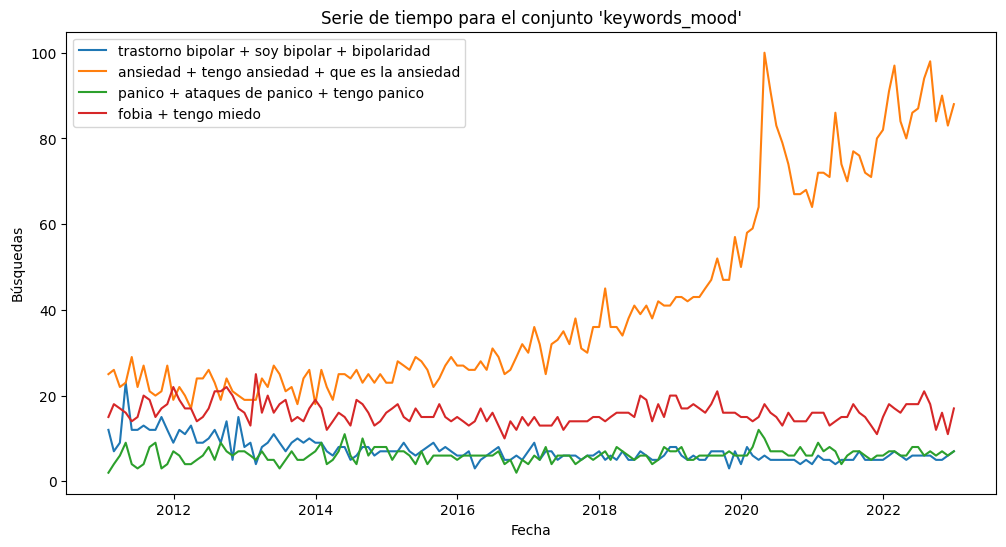

In [ ]:
subset_name = list(monthly_dfs.keys())[3]
subset_data = monthly_dfs[subset_name]

# Configura el tamaño de la figura
plt.figure(figsize=(12, 6))

# Itera a través de las columnas y traza cada una como una serie de tiempo
for column_name in subset_data.columns:
    plt.plot(subset_data.index, subset_data[column_name], label=column_name)

# Configura el título y las etiquetas de los ejes
plt.title(f"Serie de tiempo para el conjunto '{subset_name}'")
plt.xlabel("Fecha")
plt.ylabel("Búsquedas")

# Muestra una leyenda con los nombres de las categorías de búsqueda
plt.legend()

# Muestra el gráfico
plt.show()

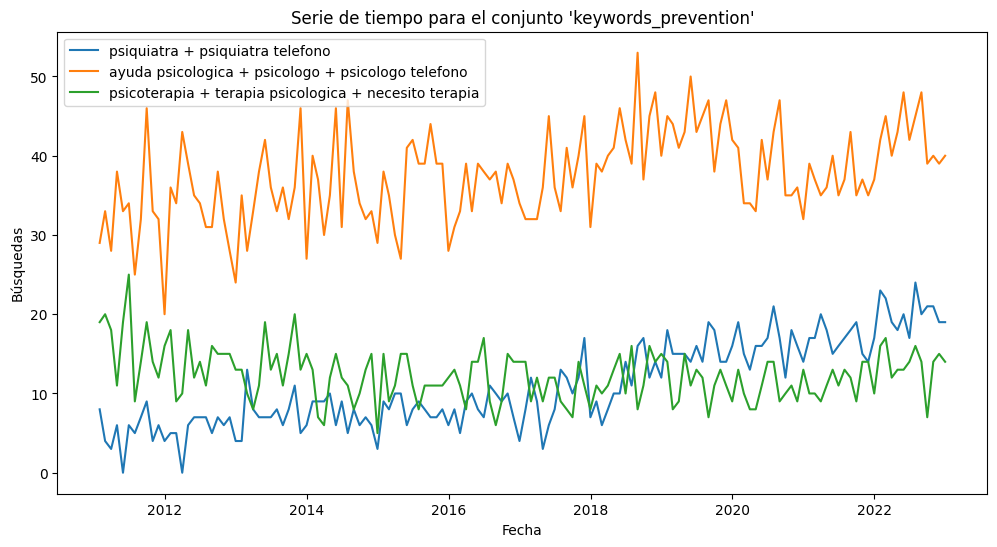

In [ ]:
subset_name = list(monthly_dfs.keys())[2]
subset_data = monthly_dfs[subset_name]

# Configura el tamaño de la figura
plt.figure(figsize=(12, 6))

# Itera a través de las columnas y traza cada una como una serie de tiempo
for column_name in subset_data.columns:
    plt.plot(subset_data.index, subset_data[column_name], label=column_name)

# Configura el título y las etiquetas de los ejes
plt.title(f"Serie de tiempo para el conjunto '{subset_name}'")
plt.xlabel("Fecha")
plt.ylabel("Búsquedas")

# Muestra una leyenda con los nombres de las categorías de búsqueda
plt.legend()

# Muestra el gráfico
plt.show()


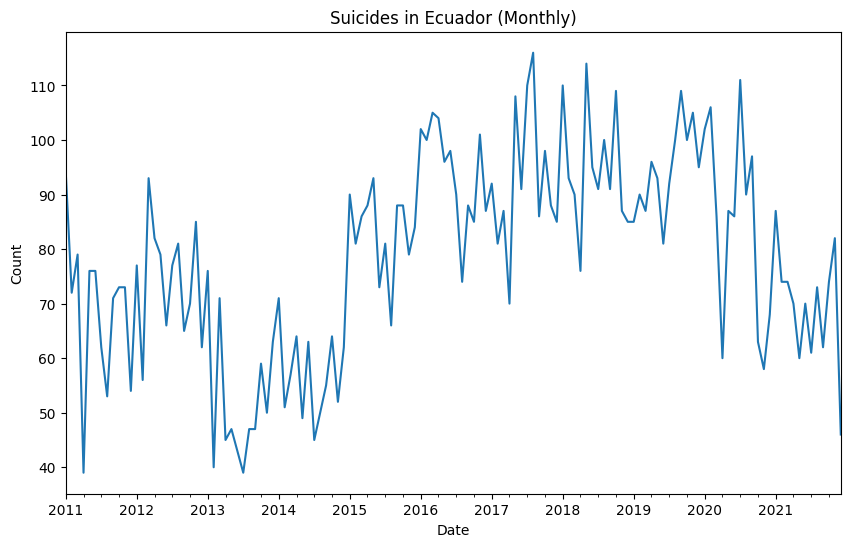

In [ ]:
df_monthly = df1.copy()
df_monthly['date'] = pd.to_datetime(df_monthly['date'])
df_monthly = df_monthly[df_monthly['date'].dt.year >= 2011]
daily_counts = df_monthly.groupby('date').size()
monthly_counts = daily_counts.resample('M').sum()
monthly_counts.plot(kind='line', figsize=(10, 6))
plt.title('Suicides in Ecuador (Monthly)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(False)
plt.show()


In [ ]:
df_monthly.head(10)

,date,province,province_code,geometry,gender,age,age_range,description
0,2011-07-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",F,26,Adults (25-34),Self-poisoning
1,2011-08-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",M,23,Young adults (20-24),Self-poisoning
2,2012-06-28,Tungurahua,18,"POLYGON ((-78.40470 -0.98958, -78.40439 -0.991...",F,14,Pre-teens (10-14),Self-poisoning
3,2012-02-28,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,21,Young adults (20-24),Self-poisoning
4,2012-02-28,Pastaza,16,"POLYGON ((-77.06133 -1.00823, -77.06137 -1.008...",M,34,Adults (25-34),Self-poisoning
5,2012-04-28,Imbabura,10,"POLYGON ((-77.81272 0.35677, -77.81255 0.35653...",F,21,Young adults (20-24),Self-poisoning
6,2012-11-28,Pichincha,17,"POLYGON ((-79.01671 0.27237, -79.01677 0.27234...",M,35,Middle-aged adults (35-44),Self-poisoning
7,2012-02-28,Bolívar,02,"POLYGON ((-78.86209 -1.19140, -78.86216 -1.191...",M,66,Retirement age (65-74),Self-poisoning
8,2013-11-28,Napo,15,"POLYGON ((-77.30554 -0.05989, -77.30550 -0.060...",M,24,Young adults (20-24),Self-poisoning
9,2018-08-28,Carchi,04,"POLYGON ((-78.49647 1.19776, -78.49573 1.19763...",M,16,Teens (15-19),Self-poisoning


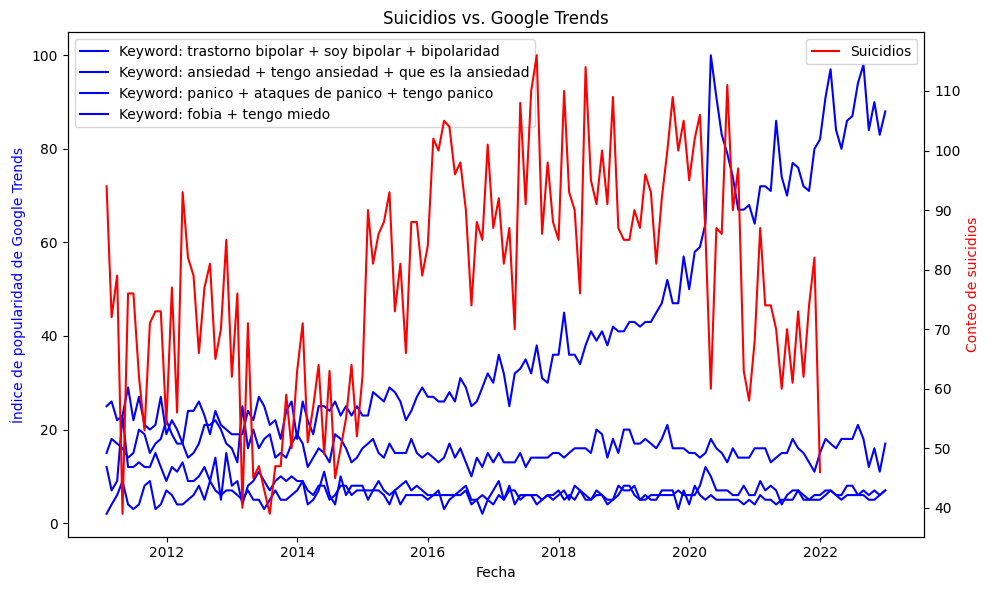

In [ ]:
# Crea la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Trama las series de búsqueda en Internet en azul
subset_name = list(monthly_dfs.keys())[3]
subset_data = monthly_dfs[subset_name]
for column_name in subset_data.columns:
    ax1.plot(subset_data.index, subset_data[column_name], color='blue', label=f'Keyword: {column_name}')

# Trama la serie de incidencia en rojo
ax2.plot(monthly_counts.index, monthly_counts, color='red', label='Suicidios')

# Configura los ejes y las etiquetas
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Índice de popularidad de Google Trends', color='blue')
ax2.set_ylabel('Conteo de suicidios', color='red')

# Configura los títulos y las leyendas
ax1.set_title('Suicidios vs. Google Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Ajusta el diseño
fig.tight_layout()

# Muestra el gráfico
plt.show()


In [ ]:
# Crear una lista con los nombres de las series de búsqueda en Internet (azul)
series_azules = list(monthly_dfs[subset_name].columns)

# Crear una lista para almacenar los valores de correlación
correlation_values = []

# Iterar a través de las series azules y calcular la correlación con la serie de suicidios (rojo)
for column_name in series_azules:
    # Calcular la correlación de Pearson
    correlation = monthly_dfs[subset_name][column_name].corr(monthly_counts, method='pearson')

    # Agregar el resultado a la lista de valores de correlación
    correlation_values.append(correlation)

# Crear un DataFrame con los nombres de las series azules y sus correlaciones correspondientes
correlation_df = pd.DataFrame({'Serie Azul': series_azules, 'Correlación': correlation_values})

# Imprimir el DataFrame de correlaciones
print(correlation_df)



                                       Serie Azul  Correlación
0   trastorno bipolar + soy bipolar + bipolaridad    -0.333203
1  ansiedad + tengo ansiedad + que es la ansiedad     0.169927
2       panico + ataques de panico + tengo panico    -0.081869
3                             fobia + tengo miedo    -0.219236


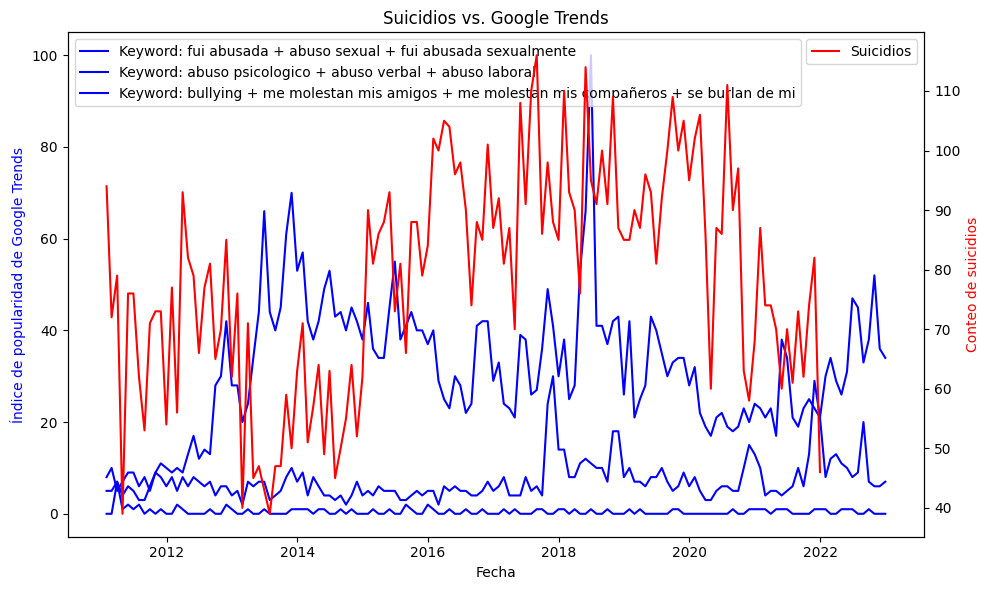

In [ ]:
# Crea la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Trama las series de búsqueda en Internet en azul
subset_name = list(monthly_dfs.keys())[5]
subset_data = monthly_dfs[subset_name]
for column_name in subset_data.columns:
    ax1.plot(subset_data.index, subset_data[column_name], color='blue', label=f'Keyword: {column_name}')

# Trama la serie de incidencia en rojo
ax2.plot(monthly_counts.index, monthly_counts, color='red', label='Suicidios')

# Configura los ejes y las etiquetas
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Índice de popularidad de Google Trends', color='blue')
ax2.set_ylabel('Conteo de suicidios', color='red')

# Configura los títulos y las leyendas
ax1.set_title('Suicidios vs. Google Trends')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Ajusta el diseño
fig.tight_layout()

# Muestra el gráfico
plt.show()

In [ ]:
# Crear una lista con los nombres de las series de búsqueda en Internet (azul)
series_azules = list(monthly_dfs[subset_name].columns)

# Crear una lista para almacenar los valores de correlación
correlation_values = []

# Iterar a través de las series azules y calcular la correlación con la serie de suicidios (rojo)
for column_name in series_azules:
    # Calcular la correlación de Pearson
    correlation = monthly_dfs[subset_name][column_name].corr(monthly_counts, method='pearson')

    # Agregar el resultado a la lista de valores de correlación
    correlation_values.append(correlation)

# Crear un DataFrame con los nombres de las series azules y sus correlaciones correspondientes
correlation_df = pd.DataFrame({'Serie Azul': series_azules, 'Correlación': correlation_values})

# Imprimir el DataFrame de correlaciones
print(correlation_df)

                                          Serie Azul  Correlación
0  fui abusada + abuso sexual + fui abusada sexua...     0.142253
1   abuso psicologico + abuso verbal + abuso laboral    -0.079449
2  bullying + me molestan mis amigos + me molesta...     0.010012


In [ ]:
# Función para calcular la correlación entre dos series
def calculate_correlation(series1, series2):
    if len(series1) < 2 or len(series2) < 2:
        return None
    correlation, p_value = stats.pearsonr(series1, series2)
    return correlation if p_value < 0.05 else None

# Función para iterar a través de los filtros y calcular la correlación
def iterate_filters_and_calculate_correlation(filter_column):
    results = []
    for filter_value, filter_data in df1[df1['date'].dt.year >= 2008].groupby(filter_column):
        # Agrupa y suma los datos por mes
        monthly_counts = filter_data.groupby('date').size().resample('M').sum()
        for subset_name, trend_data in monthly_dfs.items():
            # Unifica las series de tendencias de búsqueda en una serie sumada
            unified_trend_series = trend_data.sum(axis=1)
            # Ambas series deben tener el mismo índice y la misma longitud
            common_index = monthly_counts.index.intersection(unified_trend_series.index)
            monthly_counts_reindexed = monthly_counts.reindex(common_index, fill_value=0)
            unified_trend_series_reindexed = unified_trend_series.reindex(common_index, fill_value=0)
            correlation_value = calculate_correlation(monthly_counts_reindexed, unified_trend_series_reindexed)
            if correlation_value is not None:  # Solo agrega resultados si hay una correlación significativa
                results.append({'filter': f'{filter_column}: {filter_value}', 'keyword_subset': subset_name, 'correlation': correlation_value})
    return pd.DataFrame(results)

# Llama a la función para cada tipo de filtro
gender_results_df = iterate_filters_and_calculate_correlation('gender')
age_range_results_df = iterate_filters_and_calculate_correlation('age_range')
province_results_df = iterate_filters_and_calculate_correlation('province')



In [ ]:
gender_results_df

,filter,keyword_subset,correlation
0,gender: F,keywords_mood,-0.194289
1,gender: F,keywords_lgbti,-0.183932
2,gender: M,keywords_neutral,-0.499767
3,gender: M,keywords_search,-0.574832
4,gender: M,keywords_prevention,0.369861
5,gender: M,keywords_mood,0.175660


In [ ]:
age_range_results_df

,filter,keyword_subset,correlation
0,age_range: Children (5-9),keywords_mood,0.330113
1,age_range: Children (5-9),keywords_stress,0.256067
2,age_range: Pre-teens (10-14),keywords_neutral,-0.196446
3,age_range: Pre-teens (10-14),keywords_search,-0.198849
4,age_range: Teens (15-19),keywords_mood,-0.245018
5,age_range: Young adults (20-24),keywords_neutral,-0.216578
6,age_range: Young adults (20-24),keywords_search,-0.223678
7,age_range: Adults (25-34),keywords_neutral,-0.293282
8,age_range: Adults (25-34),keywords_search,-0.372765
9,age_range: Adults (25-34),keywords_prevention,0.216668


In [ ]:
province_results_df

,filter,keyword_subset,correlation
0,province: Azuay,keywords_neutral,-0.300650
1,province: Azuay,keywords_prevention,0.203426
2,province: Bolívar,keywords_mood,-0.190741
3,province: Chimborazo,keywords_neutral,-0.259899
4,province: Chimborazo,keywords_search,-0.226633
5,province: El Oro,keywords_neutral,-0.249043
6,province: El Oro,keywords_search,-0.276004
7,province: El Oro,keywords_prevention,0.229763
8,province: El Oro,keywords_mood,0.247138
9,province: El Oro,keywords_lgbti,0.208876


In [ ]:
# Función para calcular la correlación entre dos series con un rezago especificado
def calculate_correlation2(series1, series2, lag):
    if len(series1) < 2 or len(series2) < 2:
        return None
    series2_lagged = series2.shift(lag).dropna()
    series1_truncated = series1.iloc[:len(series2_lagged)]
    correlation, p_value = stats.pearsonr(series1_truncated, series2_lagged)
    return correlation if p_value < 0.05 else None

# Función para iterar a través de los filtros y calcular la correlación con varios rezagos
def iterate_filters_and_calculate_correlation2(filter_column):
    results = []
    for filter_value, filter_data in df1[df1['date'].dt.year >= 2008].groupby(filter_column):
        # Agrupa y suma los datos por mes
        monthly_counts = filter_data.groupby('date').size().resample('M').sum()
        for subset_name, trend_data in monthly_dfs.items():
            # Unifica las series de tendencias de búsqueda en una serie sumada
            unified_trend_series = trend_data.sum(axis=1)
            # Ambas series deben tener el mismo índice y la misma longitud
            common_index = monthly_counts.index.intersection(unified_trend_series.index)
            monthly_counts_reindexed = monthly_counts.reindex(common_index, fill_value=0)
            unified_trend_series_reindexed = unified_trend_series.reindex(common_index, fill_value=0)
            # Calcula y almacena la correlación para cada rezago
            correlations = {
                'filter': f'{filter_column}: {filter_value}',
                'keyword_subset': subset_name
            }
            for lag in range(1, 4):  # rezagos 1, 2, 3
                correlation_value = calculate_correlation2(monthly_counts_reindexed, unified_trend_series_reindexed, lag)
                correlations[f'correlation_lag_{lag}'] = correlation_value
            results.append(correlations)
    return pd.DataFrame(results)

# Llama a la función para cada tipo de filtro
gender_results_df2 = iterate_filters_and_calculate_correlation2('gender')
age_range_results_df2 = iterate_filters_and_calculate_correlation2('age_range')
province_results_df2 = iterate_filters_and_calculate_correlation2('province')


In [ ]:
gender_results_df2

,filter,keyword_subset,correlation_lag_1,correlation_lag_2,correlation_lag_3
0,gender: F,keywords_neutral,NaN,NaN,NaN
1,gender: F,keywords_search,NaN,NaN,NaN
2,gender: F,keywords_prevention,NaN,NaN,NaN
3,gender: F,keywords_mood,NaN,-0.186892,-0.193832
4,gender: F,keywords_stress,NaN,NaN,NaN
5,gender: F,keywords_traumas,NaN,NaN,NaN
6,gender: F,keywords_lgbti,-0.199680,-0.195778,-0.196293
7,gender: F,keywords_ethnics,NaN,NaN,NaN
8,gender: M,keywords_neutral,-0.505612,-0.510650,-0.515962
9,gender: M,keywords_search,-0.588082,-0.589805,-0.593660


In [ ]:
age_range_results_df2

,filter,keyword_subset,correlation_lag_1,correlation_lag_2,correlation_lag_3
0,age_range: Infants and toddlers (0-4),keywords_neutral,NaN,NaN,NaN
1,age_range: Infants and toddlers (0-4),keywords_search,NaN,NaN,NaN
2,age_range: Infants and toddlers (0-4),keywords_prevention,NaN,NaN,NaN
3,age_range: Infants and toddlers (0-4),keywords_mood,NaN,NaN,NaN
4,age_range: Infants and toddlers (0-4),keywords_stress,NaN,NaN,NaN
...,...,...,...,...,...
91,age_range: Very elderly (+85),keywords_mood,NaN,NaN,NaN
92,age_range: Very elderly (+85),keywords_stress,NaN,NaN,NaN
93,age_range: Very elderly (+85),keywords_traumas,0.183978,0.18106,0.177428
94,age_range: Very elderly (+85),keywords_lgbti,NaN,NaN,NaN


In [ ]:
province_results_df2

,filter,keyword_subset,correlation_lag_1,correlation_lag_2,correlation_lag_3
0,province: Azuay,keywords_neutral,-0.302968,-0.296374,-0.293429
1,province: Azuay,keywords_search,NaN,NaN,NaN
2,province: Azuay,keywords_prevention,NaN,NaN,NaN
3,province: Azuay,keywords_mood,NaN,NaN,NaN
4,province: Azuay,keywords_stress,NaN,NaN,NaN
...,...,...,...,...,...
203,province: Zonas no delimitadas,keywords_mood,NaN,NaN,NaN
204,province: Zonas no delimitadas,keywords_stress,NaN,NaN,NaN
205,province: Zonas no delimitadas,keywords_traumas,NaN,NaN,NaN
206,province: Zonas no delimitadas,keywords_lgbti,NaN,NaN,NaN
